In [ ]:
# Essential DS libraries
import numpy as np
import pandas as pd
import gc
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

pd.set_option('display.max_columns', 50)

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from lightautoml.text.nn_model import TorchUniversalModel
from lightautoml.text.embed import PLREmbedding, WeightedCatEmbedding, pooling_by_name
from lightautoml.ml_algo.torch_based.fttransformer.fttransformer_utils import Transformer
from collections import OrderedDict
from typing import List, Tuple, Type
from typing import Optional
from typing import Union

import numpy as np
import torch
import torch.nn as nn

from lightautoml.text.nn_model import TorchUniversalModel
from lightautoml.text.embed import PLREmbedding, WeightedCatEmbedding, pooling_by_name
from lightautoml.ml_algo.torch_based.fttransformer.fttransformer_utils import Transformer
from collections import OrderedDict
from typing import List, Tuple, Type
from typing import Optional
from typing import Union

import numpy as np
import torch
import torch.nn as nn

from transformers import BertConfig, BertModel, BertForSequenceClassification
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

class BertEmbeddingsEmpty(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self):
        super().__init__()

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file


    def forward(self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, **kwargs):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        embeddings = inputs_embeds
        return embeddings
class FTTransformer2(nn.Module):
    """FT Transformer (https://arxiv.org/abs/2106.11959v2) from https://github.com/lucidrains/tab-transformer-pytorch/tree/main.

    Args:
            pooling: Pooling used for the last step.
            n_out: Output dimension, 1 for binary prediction.
            embedding_size: Embeddings size.
            depth: Number of Attention Blocks inside Transformer.
            heads: Number of heads in Attention.
            attn_dropout: Post-Attention dropout.
            ff_dropout: Feed-Forward Dropout.
            dim_head: Attention head dimension.
            num_enc_layers: Number of Transformer layers.
            device: Device to compute on.
    """

    def __init__(
        self,
        *,
        pooling: str = "mean",
        n_out: int = 1,
        embedding_size: int = 32,
        depth: int = 4,
        heads: int = 1,
        attn_dropout: float = 0.1,
        ff_dropout: float = 0.1,
        dim_head: int = 32,
        num_enc_layers: int = 2,
        device: Union[str, torch.device] = "cuda:0",
        **kwargs,
    ):
        super(FTTransformer2, self).__init__()
        self.device = device
        self.pooling = pooling_by_name[pooling]()
        print('pooling', pooling)
    
        # transformer
        # self.transformer = nn.Sequential(
        #     *nn.ModuleList(
        #         [
        #             Transformer(
        #                 dim=embedding_size,
        #                 depth=depth,
        #                 heads=heads,
        #                 dim_head=dim_head,
        #                 attn_dropout=attn_dropout,
        #                 ff_dropout=ff_dropout,
        #             )
        #             for _ in range(num_enc_layers)
        #         ]
        #     )
        # )
        self.conf = {"hidden_size": 128, "hidden_act": "gelu", "initializer_range": 0.02, "vocab_size": 10, "hidden_dropout_prob": 0.1, "num_attention_heads": 2,
         "type_vocab_size": 2, "max_position_embeddings": 512, "num_hidden_layers": 2, "intermediate_size": 512, "attention_probs_dropout_prob": 0.1} #bert_tiny
        # self.conf = {"hidden_size": 512, "hidden_act": "gelu", "initializer_range": 0.02, "vocab_size": 10, "hidden_dropout_prob": 0.1, "num_attention_heads": 8,
        # "type_vocab_size": 2, "max_position_embeddings": 512, "num_hidden_layers": 4, "intermediate_size": 2048, "attention_probs_dropout_prob": 0.1} #bert_small

        #self.transformer = BertModel(BertConfig(**self.conf))
        self.transformer = BertModel.from_pretrained("prajjwal1/bert-tiny", output_attentions=True, output_hidden_states=True, cache_dir="./")
        self.transformer.embeddings = BertEmbeddingsEmpty()

        #peft_config = LoraConfig(task_type=TaskType.FEATURE_EXTRACTION, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)

        #self.transformer = get_peft_model(self.transformer, peft_config)
        #print(self.transformer.print_trainable_parameters())

        #self.fixup_initialization()
        # to logits
    
        self.to_logits = nn.Sequential(nn.BatchNorm1d(embedding_size), nn.Linear(embedding_size, n_out))

        self.cls_token = nn.Embedding(2, embedding_size)

    def fixup_initialization(self):
        temp_state_dic = {}
        en_layers = self.conf['num_hidden_layers']

        for name, param in self.named_parameters():
            if 'weight' in name and param.data.dim() == 2:
                param = (9 * en_layers) ** (- 1 / 4) * param
                temp_state_dic[name] = param
            if np.any([1 if i in name else 0 for i in ["linear1.weight",
                        "linear2.weight",
                        "self_attn.out_proj.weight", #'self_attn.in_proj_weight', 
                        ]]):
                temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * param
            elif name in ["self_attn.v_proj.weight",]:
                temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * (param * (2**0.5))

        for name in self.state_dict():
            if name not in temp_state_dic:
                temp_state_dic[name] = self.state_dict()[name]
        self.load_state_dict(temp_state_dic)

    def forward(self, embedded):
        """Transform the input tensor.

        Args:
            embedded : torch.Tensor
                embedded fields

        Returns:
            torch.Tensor

        """
        cls_token = torch.unsqueeze(
            self.cls_token(torch.ones(embedded.shape[0], dtype=torch.int).to(self.device)), dim=1
        )
        x = torch.cat((cls_token, embedded), dim=1)

        x = self.transformer(inputs_embeds=x, 
                    #attention_mask=~mask
                    ).last_hidden_state
        #x = self.transformer(x)
        x_mask = torch.ones(x.shape, dtype=torch.bool).to(self.device)
        pool_tokens = self.pooling(x=x, x_mask=x_mask)
        logits = self.to_logits(pool_tokens)
        return logits


class FTT_plus(TorchUniversalModel):
    """Mixed data model.

    Class for preparing input for DL model with mixed data.

    Args:
            n_out: Number of output dimensions.
            cont_params: Dict with numeric model params.
            cat_params: Dict with category model para
            **kwargs: Loss, task and other parameters.

        """

    def __init__(
            self,
            n_out: int = 1,
            cont_params = None,
            cat_params = None,
            **kwargs,
    ):
        # init parent class (need some helper functions to be used)
        super(FTT_plus, self).__init__(**{
                **kwargs,
                "cont_params": cont_params,
                "cat_params": cat_params,
                "torch_model": None, # dont need any model inside parent class
        })
        
        n_in = 0
        # add cont columns processing
        self.cont_embedder = PLREmbedding(**cont_params)
        n_in += self.cont_embedder.get_out_shape()
        
        # add cat columns processing
        self.cat_embedder = WeightedCatEmbedding(**cat_params)
        n_in += self.cat_embedder.get_out_shape()
        
        self.torch_model = FTTransformer2(
                **{
                    **kwargs,
                    **{"n_in": n_in, "n_out": n_out},
                }
        )
    
    def get_logits(self, inp) -> torch.Tensor:
        outputs = []
        outputs.append(self.cont_embedder(inp))
        outputs.append(self.cat_embedder(inp))
        
        if len(outputs) > 1:
            output = torch.cat(outputs, dim=1)
        else:
            output = outputs[0]
        
        logits = self.torch_model(output)
        return logits

def myround(x, base=1000):
    return base * np.round(np.float32(x) / base)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train_add = pd.read_csv('data/train_add.csv')

all_data = pd.concat([train, train_add, test]).reset_index(drop = True)
all_data.head()

def convert_engine(val):
    d = {
        'engine_HP': np.nan,
        'engine_L': np.nan,
        'engine_cylinder': np.nan,
        'engine_cylinder_type': np.nan,
        'engine_fuel_type': np.nan,
        'engine_type': np.nan,
        'engine_v': np.nan,
        'engine_vtype': np.nan
    }
    spl = val.replace('-', '').split(' ')
    pos_v1 = -1
    pos_v2 = -1
    for i, v in enumerate(spl):
        if v.endswith('HP'):
            d['engine_HP'] = float(v[:-2])
        elif v.endswith('L'):
            d['engine_L'] = float(v[:-1])
        elif v == 'Engine' and spl[i-1] == 'Cylinder':
            d['engine_cylinder'] = abs(float(spl[i-2].replace('V', '')))
        elif v == 'Fuel':
            d['engine_fuel_type'] = spl[i - 1]
        ##############
        elif v == 'Liter':
            d['engine_L'] = float(spl[i-1])
        elif v.startswith('V') or v.startswith('H') or v.startswith('I'):
            try:
                d['engine_cylinder'] = float(v[1:])
                d['engine_cylinder_type'] = v[0]
                pos_v1 = i
            except:
                pass
        elif v == 'DOHC' or v == 'OHV':
            d['engine_type'] = ' '.join(spl[i:])
            if pos_v2 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v2+1:i])
            elif pos_v1 != -1:
                d['engine_vtype'] = ' '.join(spl[pos_v1+1:i])
        elif v.endswith('V'):
            try:
                d['engine_v'] = float(v[:-1])
                pos_v2 = i
            except:
                pass
    return d

all_data = pd.concat([all_data, pd.DataFrame.from_records(all_data['engine'].map(convert_engine).values)], axis = 1)
def milage_signs(val):
    v = str(val)
    for i in range(len(v) - 1, -1, -1):
        if v[i] != '0':
            break
    return (len(v) - 1 - i) / len(v) * 100


all_data['milage_signif_signs_perc'] = all_data['milage'].map(milage_signs)
for col in ['transmission', 'ext_col', 'int_col']:
    all_data[col] = all_data[col].str.lower()

def convert_transmission(val):
    d = {
        'transmission_speeds_cnt': np.nan,
        'transmission_type': np.nan
    }
    spl = val.replace('/', '').split(' ')
    for i, v in enumerate(spl):
        if 'speed' in v:
            tmp = v.split('-')
            if len(tmp) > 1:
                if tmp[0] != 'single':
                    d['transmission_speeds_cnt'] = float(tmp[0])
                else:
                    d['transmission_speeds_cnt'] = 1.0
            else:
                d['transmission_speeds_cnt'] = float(spl[i-1])
        elif 'manual' in v or 'mt' in v:
            d['transmission_type'] = 'manual'
        elif 'automatic' in v or 'at' in v:
            d['transmission_type'] = 'automatic'
    return d

all_data = pd.concat([all_data, pd.DataFrame.from_records(all_data['transmission'].map(convert_transmission).values)], axis = 1)

# all_data['mileage_year_delta_mean'] = all_data['milage'] - all_data['model_year'].map(all_data.groupby(['model_year'])['milage'].mean())
# all_data['mileage_year_delta_median'] = all_data['milage'] - all_data['model_year'].map(all_data.groupby(['model_year'])['milage'].median())

# all_data['tmp'] = (all_data['brand'].astype(str) + '_' + all_data['model_year'].astype(str))
# all_data['mileage_brandyear_delta_mean'] = all_data['milage'] - all_data['tmp'].map(all_data.groupby(['tmp'])['milage'].mean())
# all_data['mileage_brandyear_delta_median'] = all_data['milage'] - all_data['tmp'].map(all_data.groupby(['tmp'])['milage'].median())

# all_data.drop(columns = ['tmp'], inplace = True)


train2, train2_add, test2 = all_data.iloc[:len(train)], all_data.iloc[len(train):len(train)+len(train_add)], all_data.iloc[len(train)+len(train_add):]
X_train2, X_val2 = train_test_split(train2, test_size=0.2, random_state=42, shuffle=True, stratify=train['price'])


In [ ]:
import joblib
from sklearn.metrics import log_loss
def ll(x, y):
    return log_loss(x, y, labels=np.arange(y.shape[1]))

cb_woclip_data = joblib.load('catboost_woclip_data.jbl')
cb_woclip_wodata = joblib.load('catboost_woclip_wodata.jbl')

cb_clip_data = joblib.load('catboost_clip_data.jbl')
cb_clip_wodata = joblib.load('catboost_clip_wodata.jbl')

lgb_woclip_data = joblib.load('lgb_woclip_data.jbl')
lgb_woclip_wodata = joblib.load('lgb_woclip_wodata.jbl')

lgb_clip_data = joblib.load('lgb_clip_data.jbl')
lgb_clip_wodata = joblib.load('lgb_clip_wodata.jbl')

dl_cls_woclip_data = joblib.load('denselight_cls_woclip_data.jbl')
dl_cls_woclip_wodata = joblib.load('denselight_cls_woclip_wodata.jbl')
dl_reg_woclip_data = joblib.load('denselight_reg_woclip_data.jbl')
dl_reg_woclip_wodata = joblib.load('denselight_reg_woclip_wodata.jbl')

dl_cls_clip_data = joblib.load('denselight_cls_clip_data.jbl')
dl_cls_clip_wodata = joblib.load('denselight_cls_clip_wodata.jbl')
dl_reg_clip_data = joblib.load('denselight_reg_clip_data.jbl')
dl_reg_clip_wodata = joblib.load('denselight_reg_clip_wodata.jbl')

ftt_cls_woclip_data = joblib.load('ftt_cls_woclip_data.jbl')
ftt_cls_woclip_wodata = joblib.load('ftt_cls_woclip_wodata.jbl')
ftt_reg_woclip_data = joblib.load('ftt_reg_woclip_data.jbl')
ftt_reg_woclip_wodata = joblib.load('ftt_reg_woclip_wodata.jbl')

ftt_cls_clip_data = joblib.load('ftt_cls_clip_data.jbl')
ftt_cls_clip_wodata = joblib.load('ftt_cls_clip_wodata.jbl')
ftt_reg_clip_data = joblib.load('ftt_reg_clip_data.jbl')
ftt_reg_clip_wodata = joblib.load('ftt_reg_clip_wodata.jbl')

In [126]:
print('cb_woclip_data', np.sqrt(mean_squared_error(train['price'],cb_woclip_data['oof'])))
print('cb_woclip_wodata',np.sqrt(mean_squared_error(train['price'],cb_woclip_wodata['oof'])))

print('cb_clip_data', np.sqrt(mean_squared_error(train['price'],cb_clip_data['oof'])))
print('cb_clip_wodata',np.sqrt(mean_squared_error(train['price'],cb_clip_wodata['oof'])))

print('========')

print('lgb_woclip_data', np.sqrt(mean_squared_error(train['price'],lgb_woclip_data['oof'])))
print('lgb_woclip_wodata', np.sqrt(mean_squared_error(train['price'],lgb_woclip_wodata['oof'])))

print('lgb_clip_data', np.sqrt(mean_squared_error(train['price'],lgb_clip_data['oof'])))
print('lgb_clip_wodata', np.sqrt(mean_squared_error(train['price'],lgb_clip_wodata['oof'])))

print('========')


print('dl_cls_woclip_data', np.sqrt(mean_squared_error(train['price'],dl_cls_woclip_data['oof'])))
print('dl_cls_woclip_wodata', np.sqrt(mean_squared_error(train['price'],dl_cls_woclip_wodata['oof'])))
print('dl_reg_woclip_data', np.sqrt(mean_squared_error(train['price'],dl_reg_woclip_data['oof'])))
print('dl_reg_woclip_wodata', np.sqrt(mean_squared_error(train['price'],dl_reg_woclip_wodata['oof'])))

print('dl_cls_clip_data', np.sqrt(mean_squared_error(train['price'],dl_cls_clip_data['oof'])))
print('dl_cls_clip_wodata', np.sqrt(mean_squared_error(train['price'],dl_cls_clip_wodata['oof'])))
print('dl_reg_clip_data', np.sqrt(mean_squared_error(train['price'],dl_reg_clip_data['oof'])))
print('dl_reg_clip_wodata', np.sqrt(mean_squared_error(train['price'],dl_reg_clip_wodata['oof'])))

print('========')


print('ftt_cls_woclip_data', np.sqrt(mean_squared_error(train['price'],ftt_cls_woclip_data['oof'])))
print('ftt_cls_woclip_wodata', np.sqrt(mean_squared_error(train['price'],ftt_cls_woclip_wodata['oof'])))
print('ftt_reg_woclip_data', np.sqrt(mean_squared_error(train['price'],ftt_reg_woclip_data['oof'])))
print('ftt_reg_woclip_wodata', np.sqrt(mean_squared_error(train['price'],ftt_reg_woclip_wodata['oof'])))

print('ftt_cls_clip_data', np.sqrt(mean_squared_error(train['price'],ftt_cls_clip_data['oof'])))
print('ftt_cls_clip_wodata', np.sqrt(mean_squared_error(train['price'],ftt_cls_clip_wodata['oof'])))
print('ftt_reg_clip_data', np.sqrt(mean_squared_error(train['price'],ftt_reg_clip_data['oof'])))
print('ftt_reg_clip_wodata', np.sqrt(mean_squared_error(train['price'],ftt_reg_clip_wodata['oof'])))

print('========')


cb_woclip_data 72618.9703478578
cb_woclip_wodata 72668.7328880977
cb_clip_data 72570.46991893183
cb_clip_wodata 72600.88262678128
lgb_woclip_data 72602.41078032415
lgb_woclip_wodata 72620.9594297133
lgb_clip_data 72601.86760677746
lgb_clip_wodata 72596.83126323734
dl_cls_woclip_data 72511.68695240283
dl_cls_woclip_wodata 72533.1908545782
dl_reg_woclip_data 72590.25331475686
dl_reg_woclip_wodata 72595.92306687857
dl_cls_clip_data 72592.14593018906
dl_cls_clip_wodata 72602.7694385295
dl_reg_clip_data 72587.226643284
dl_reg_clip_wodata 72592.09624284969
ftt_cls_woclip_data 72588.59375538873
ftt_cls_woclip_wodata 72624.15051167678
ftt_reg_woclip_data 72929.32519290179
ftt_reg_woclip_wodata 72895.44063224178
ftt_cls_clip_data 72609.67167200606
ftt_cls_clip_wodata 72630.22898181618
ftt_reg_clip_data 72674.23620941052
ftt_reg_clip_wodata 72674.24512099774


In [154]:
print('============ clip ===========')


cb_blend1 = 0.7*cb_clip_data['oof'] + 0.3*cb_clip_wodata['oof']
print('cb_blend1', np.sqrt(mean_squared_error(train['price'],cb_blend1)))

lgb_blend1 = 0.5*lgb_clip_data['oof'] + 0.5*lgb_clip_wodata['oof']
print('lgb_blend1', np.sqrt(mean_squared_error(train['price'],lgb_blend1)))

dl_reg_blend1 = 0.4*dl_reg_clip_data['oof'] + 0.6*dl_reg_clip_wodata['oof']
print('dl_reg_blend1', np.sqrt(mean_squared_error(train['price'],dl_reg_blend1)))

dl_cls_blend1 = 0.6*dl_cls_clip_data['oof'] + 0.4*dl_cls_clip_wodata['oof']
print('dl_cls_blend1', np.sqrt(mean_squared_error(train['price'],dl_cls_blend1)))

ftt_reg_blend1 = 0.5*ftt_reg_clip_data['oof'] + 0.5*ftt_reg_clip_wodata['oof']
print('ftt_reg_blend1', np.sqrt(mean_squared_error(train['price'],ftt_reg_blend1)))

ftt_cls_blend1 = 0.6*ftt_cls_clip_data['oof'] + 0.4*ftt_cls_clip_wodata['oof']
print('ftt_cls_blend1', np.sqrt(mean_squared_error(train['price'],ftt_cls_blend1)))


gbm_blend1 = 0.6*cb_blend1 + 0.4*lgb_blend1
print('gbm_blend1', np.sqrt(mean_squared_error(train['price'], gbm_blend1)))

dl_blend1 = 0.4*dl_reg_blend1 + 0.6*dl_cls_blend1
print('dl_blend1', np.sqrt(mean_squared_error(train['price'], dl_blend1)))

ftt_blend1 = 0.4*ftt_reg_blend1 + 0.6*ftt_cls_blend1
print('ftt_blend1', np.sqrt(mean_squared_error(train['price'], ftt_blend1)))

all_blend1 = 0.4*gbm_blend1 + 0.45*dl_blend1 + 0.15*ftt_blend1
print('all_blend1', np.sqrt(mean_squared_error(train['price'], all_blend1)))

print('============ no clip ===========')

cb_blend = 0.7*cb_woclip_data['oof'] + 0.3*cb_woclip_wodata['oof']
print('cb_blend', np.sqrt(mean_squared_error(train['price'],cb_blend)))

lgb_blend = 0.6*lgb_woclip_data['oof'] + 0.4*lgb_woclip_wodata['oof']
print('lgb_blend', np.sqrt(mean_squared_error(train['price'],lgb_blend)))

dl_reg_blend = 0.5*dl_reg_woclip_data['oof'] + 0.5*dl_reg_woclip_wodata['oof']
print('dl_reg_blend', np.sqrt(mean_squared_error(train['price'],dl_reg_blend)))

dl_cls_blend = 0.6*dl_cls_woclip_data['oof'] + 0.4*dl_cls_woclip_wodata['oof']
print('dl_cls_blend', np.sqrt(mean_squared_error(train['price'],dl_cls_blend)))

ftt_reg_blend = 0.5*ftt_reg_woclip_data['oof'] + 0.5*ftt_reg_woclip_wodata['oof']
print('ftt_reg_blend', np.sqrt(mean_squared_error(train['price'],ftt_reg_blend)))

ftt_cls_blend = 0.6*ftt_cls_woclip_data['oof'] + 0.4*ftt_cls_woclip_wodata['oof']
print('ftt_cls_blend', np.sqrt(mean_squared_error(train['price'],ftt_cls_blend)))


gbm_blend = 0.4*cb_blend1 + 0.4*lgb_blend + 0.2 * cb_blend
print('gbm_blend', np.sqrt(mean_squared_error(train['price'], gbm_blend)))

dl_blend = 0.4*dl_reg_blend + 0.6*dl_cls_blend
print('dl_blend', np.sqrt(mean_squared_error(train['price'], dl_blend)))

ftt_blend = 0.3*ftt_reg_blend + 0.7*ftt_cls_blend 
print('ftt_blend', np.sqrt(mean_squared_error(train['price'], ftt_blend)))

all_blend = 0.25*gbm_blend + 0.6*dl_blend + 0.15*ftt_blend
print('all_blend', np.sqrt(mean_squared_error(train['price'], all_blend)))

print('============ final ===========')



============ clip ===========
cb_blend1 72562.41639936849
lgb_blend1 72577.25042227953
dl_reg_blend1 72570.4577558202
dl_cls_blend1 72576.6460432608
ftt_reg_blend1 72630.82437226783
ftt_cls_blend1 72590.73705499641
gbm_blend1 72537.53694244122
dl_blend1 72525.34974947025
ftt_blend1 72535.56219749196
all_blend1 72482.96183545176
============ no clip ===========
cb_blend 72603.17802993162
lgb_blend 72577.56619206312
dl_reg_blend 72554.10550246558
dl_cls_blend 72493.64674517023
ftt_reg_blend 72826.89400857108
ftt_cls_blend 72562.48338206876
gbm_blend 72510.79114053813
dl_blend 72431.63394545649
ftt_blend 72487.94472391986
all_blend 72409.36716955696
============ final ===========


In [ ]:
cb_blend 72603.17802993162
lgb_blend 72577.56619206312
dl_reg_blend 72554.10550246558
dl_cls_blend 72493.64674517023
ftt_reg_blend 72826.89400857108
ftt_cls_blend 72562.48338206876
gbm_blend 72510.79114053813
dl_blend 72431.63394545649
ftt_blend 72487.94472391986
all_blend 72409.36716955696

In [91]:
joblib.dump(all_blend, 'predict_72075_additional_test.jbl')

['predict_72075_additional_test.jbl']

In [ ]:
train_stack = train2[['price']]
train_stack['cb_woclip_data']=cb_woclip_data['oof']
train_stack['cb_woclip_wodata']=cb_woclip_wodata['oof']

train_stack['cb_clip_data']=cb_clip_data['oof']
train_stack['cb_clip_wodata']=cb_clip_wodata['oof']

print('========')

train_stack['lgb_woclip_data']=lgb_woclip_data['oof']
train_stack['lgb_woclip_wodata']=lgb_woclip_wodata['oof']

train_stack['lgb_clip_data']=lgb_clip_data['oof']
train_stack['lgb_clip_wodata']=lgb_clip_wodata['oof']

print('========')


train_stack['dl_cls_woclip_data']=dl_cls_woclip_data['oof']
train_stack['dl_cls_woclip_wodata']=dl_cls_woclip_wodata['oof']
train_stack['dl_reg_woclip_data']=dl_reg_woclip_data['oof']
train_stack['dl_reg_woclip_wodata']=dl_reg_woclip_wodata['oof']

train_stack['dl_cls_clip_data']=dl_cls_clip_data['oof']
train_stack['dl_cls_clip_wodata']=dl_cls_clip_wodata['oof']
train_stack['dl_reg_clip_data']=dl_reg_clip_data['oof']
train_stack['dl_reg_clip_wodata']=dl_reg_clip_wodata['oof']

print('========')


train_stack['ftt_cls_woclip_data']=ftt_cls_woclip_data['oof']
train_stack['ftt_cls_woclip_wodata']=ftt_cls_woclip_wodata['oof']
train_stack['ftt_reg_woclip_data']=ftt_reg_woclip_data['oof']
train_stack['ftt_reg_woclip_wodata']=ftt_reg_woclip_wodata['oof']

train_stack['ftt_cls_clip_data']=ftt_cls_clip_data['oof']
train_stack['ftt_cls_clip_wodata']=ftt_cls_clip_wodata['oof']
train_stack['ftt_reg_clip_data']=ftt_reg_clip_data['oof']
train_stack['ftt_reg_clip_wodata']=ftt_reg_clip_wodata['oof']

print('AAAAAAAA')
test_stack = test2[['id']]
test_stack['cb_woclip_data']=cb_woclip_data['pred']
test_stack['cb_woclip_wodata']=cb_woclip_wodata['pred']

test_stack['cb_clip_data']=cb_clip_data['pred']
test_stack['cb_clip_wodata']=cb_clip_wodata['pred']

print('========')

test_stack['lgb_woclip_data']=lgb_woclip_data['pred']
test_stack['lgb_woclip_wodata']=lgb_woclip_wodata['pred']

test_stack['lgb_clip_data']=lgb_clip_data['pred']
test_stack['lgb_clip_wodata']=lgb_clip_wodata['pred']

print('========')


test_stack['dl_cls_woclip_data']=dl_cls_woclip_data['pred']
test_stack['dl_cls_woclip_wodata']=dl_cls_woclip_wodata['pred']
test_stack['dl_reg_woclip_data']=dl_reg_woclip_data['pred']
test_stack['dl_reg_woclip_wodata']=dl_reg_woclip_wodata['pred']

test_stack['dl_cls_clip_data']=dl_cls_clip_data['pred']
test_stack['dl_cls_clip_wodata']=dl_cls_clip_wodata['pred']
test_stack['dl_reg_clip_data']=dl_reg_clip_data['pred']
test_stack['dl_reg_clip_wodata']=dl_reg_clip_wodata['pred']

print('========')


test_stack['ftt_cls_woclip_data']=ftt_cls_woclip_data['pred']
test_stack['ftt_cls_woclip_wodata']=ftt_cls_woclip_wodata['pred']
test_stack['ftt_reg_woclip_data']=ftt_reg_woclip_data['pred']
test_stack['ftt_reg_woclip_wodata']=ftt_reg_woclip_wodata['pred']

test_stack['ftt_cls_clip_data']=ftt_cls_clip_data['pred']
test_stack['ftt_cls_clip_wodata']=ftt_cls_clip_wodata['pred']
test_stack['ftt_reg_clip_data']=ftt_reg_clip_data['pred']
test_stack['ftt_reg_clip_wodata']=ftt_reg_clip_wodata['pred']

print('========')



In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
task = Task('reg')
oof2 = np.zeros(len(train2))
pred = 0
models = {}
if True:
    for fold, (tr_idx, te_idx) in enumerate(KFold(n_splits=10, random_state=42, shuffle=True).split(train_stack['price'], train_stack['price'], None)):
        x_tr, x_vl = train_stack.iloc[tr_idx].reset_index(drop=True), train_stack.iloc[te_idx].reset_index(drop=True)
        #if add_data is not None:
        #    x_tr = pd.concat([x_tr, train2_add], axis=0).reset_index(drop=True)
        
        #x_tr['price'] = np.clip(x_tr['price'], 0, 500_000)

        scaler = RobustScaler()
        scaler.fit(x_tr['price'].values.reshape(-1, 1))
        x_tr['price'] = scaler.transform(x_tr['price'].values.reshape(-1, 1))
        x_vl['price'] = scaler.transform(x_vl['price'].values.reshape(-1, 1))

        automl1 = TabularAutoML(debug=True,
        task = task, 
        timeout = 600 * 3600,
        cpu_limit = 2, 
        gpu_ids = '1',
        selection_params = {'mode': 0},
        general_params = {"use_algos": [['denselight']]}, 
        nn_params = {
            "n_epochs": 10, 
            "bs": 1024//2, 
            "num_workers": 0, 
            "path_to_save": None, 
            "freeze_defaults": True,
            #"cont_embedder": 'plr',
            'cat_embedder': 'weighted',
            'act_fun': 'GELU',#'SiLU',
            "hidden_size": [64, 32], #32,
            'stop_by_metric': True,
            'embedding_size': 37,#32,
            'verbose_bar': True,
            'input_bn': False,
            'opt_params': { 'lr': 0.0003 , 'weight_decay': 0 }
        },
        nn_pipeline_params = {"use_qnt": False, "use_te": False},
        reader_params = {'n_jobs': 5, 'cv': 10, 'random_state': 42, 'advanced_roles': False})

        out_of_fold_predictions = automl1.fit_predict(
            x_tr, valid_data = x_vl, 
            roles = {
                'target': 'price',
                'drop': ['id'],
                
            }, 
            verbose = 1)
        oof2[te_idx] = scaler.inverse_transform(out_of_fold_predictions.data.flatten().reshape(-1, 1)).flatten()
        #oof[te_idx] = out_of_fold_predictions.data.flatten().reshape(-1, 1).flatten()

        pred += scaler.inverse_transform(automl1.predict(test_stack).data.flatten().reshape(-1, 1)).flatten() / 10
        #pred_add += (automl1.predict(test2_add).data  @ values.reshape(-1, 1)).flatten() / 10

        models[fold] = automl1
    #res_dl_cls = {'oof': oof, 'pred': pred, 'pred_add': pred_add, 'models': models}
    #joblib.dump(res_dl_cls, f'denselight_cls_{clip_name}_{data_name}.jbl')
    print(f'oof', np.sqrt(mean_squared_error(train2['price'], oof2)))

In [176]:
res_dl_cls = {'oof': oof2, 'pred': pred, 'models': models}
joblib.dump(res_dl_cls, f'stack_denselight_reg.jbl')

['stack_denselight_reg.jbl']

In [187]:
print('============ clip ===========')


cb_blend1 = 0.7*cb_clip_data['oof'] + 0.3*cb_clip_wodata['oof']
print('cb_blend1', np.sqrt(mean_squared_error(train['price'],cb_blend1)))

lgb_blend1 = 0.5*lgb_clip_data['oof'] + 0.5*lgb_clip_wodata['oof']
print('lgb_blend1', np.sqrt(mean_squared_error(train['price'],lgb_blend1)))

dl_reg_blend1 = 0.4*dl_reg_clip_data['oof'] + 0.6*dl_reg_clip_wodata['oof']
print('dl_reg_blend1', np.sqrt(mean_squared_error(train['price'],dl_reg_blend1)))

dl_cls_blend1 = 0.6*dl_cls_clip_data['oof'] + 0.4*dl_cls_clip_wodata['oof']
print('dl_cls_blend1', np.sqrt(mean_squared_error(train['price'],dl_cls_blend1)))

ftt_reg_blend1 = 0.5*ftt_reg_clip_data['oof'] + 0.5*ftt_reg_clip_wodata['oof']
print('ftt_reg_blend1', np.sqrt(mean_squared_error(train['price'],ftt_reg_blend1)))

ftt_cls_blend1 = 0.6*ftt_cls_clip_data['oof'] + 0.4*ftt_cls_clip_wodata['oof']
print('ftt_cls_blend1', np.sqrt(mean_squared_error(train['price'],ftt_cls_blend1)))


gbm_blend1 = 0.6*cb_blend1 + 0.4*lgb_blend1
print('gbm_blend1', np.sqrt(mean_squared_error(train['price'], gbm_blend1)))

dl_blend1 = 0.4*dl_reg_blend1 + 0.6*dl_cls_blend1
print('dl_blend1', np.sqrt(mean_squared_error(train['price'], dl_blend1)))

ftt_blend1 = 0.4*ftt_reg_blend1 + 0.6*ftt_cls_blend1
print('ftt_blend1', np.sqrt(mean_squared_error(train['price'], ftt_blend1)))

all_blend1 = 0.4*gbm_blend1 + 0.45*dl_blend1 + 0.15*ftt_blend1
print('all_blend1', np.sqrt(mean_squared_error(train['price'], all_blend1)))

print('============ no clip ===========')

cb_blend = 0.7*cb_woclip_data['oof'] + 0.3*cb_woclip_wodata['oof']
print('cb_blend', np.sqrt(mean_squared_error(train['price'],cb_blend)))

lgb_blend = 0.6*lgb_woclip_data['oof'] + 0.4*lgb_woclip_wodata['oof']
print('lgb_blend', np.sqrt(mean_squared_error(train['price'],lgb_blend)))

dl_reg_blend = 0.5*dl_reg_woclip_data['oof'] + 0.5*dl_reg_woclip_wodata['oof']
print('dl_reg_blend', np.sqrt(mean_squared_error(train['price'],dl_reg_blend)))

dl_cls_blend = 0.6*dl_cls_woclip_data['oof'] + 0.4*dl_cls_woclip_wodata['oof']
print('dl_cls_blend', np.sqrt(mean_squared_error(train['price'],dl_cls_blend)))

ftt_reg_blend = 0.5*ftt_reg_woclip_data['oof'] + 0.5*ftt_reg_woclip_wodata['oof']
print('ftt_reg_blend', np.sqrt(mean_squared_error(train['price'],ftt_reg_blend)))

ftt_cls_blend = 0.6*ftt_cls_woclip_data['oof'] + 0.4*ftt_cls_woclip_wodata['oof']
print('ftt_cls_blend', np.sqrt(mean_squared_error(train['price'],ftt_cls_blend)))


gbm_blend = 0.4*cb_blend1 + 0.4*lgb_blend + 0.2 * cb_blend
print('gbm_blend', np.sqrt(mean_squared_error(train['price'], gbm_blend)))

dl_blend = 0.4*dl_reg_blend + 0.6*dl_cls_blend
print('dl_blend', np.sqrt(mean_squared_error(train['price'], dl_blend)))

ftt_blend = 0.3*ftt_reg_blend + 0.7*ftt_cls_blend 
print('ftt_blend', np.sqrt(mean_squared_error(train['price'], ftt_blend)))

all_blend = 0.25*gbm_blend + 0.6*dl_blend + 0.15*ftt_blend
print('all_blend', np.sqrt(mean_squared_error(train['price'], all_blend)))

print('============ final ===========')
final = 0.3*all_blend + 0.7*oof2
print('final', np.sqrt(mean_squared_error(train['price'], final)))


============ clip ===========
cb_blend1 72562.41639936849
lgb_blend1 72577.25042227953
dl_reg_blend1 72570.4577558202
dl_cls_blend1 72576.6460432608
ftt_reg_blend1 72630.82437226783
ftt_cls_blend1 72590.73705499641
gbm_blend1 72537.53694244122
dl_blend1 72525.34974947025
ftt_blend1 72535.56219749196
all_blend1 72482.96183545176
============ no clip ===========
cb_blend 72603.17802993162
lgb_blend 72577.56619206312
dl_reg_blend 72554.10550246558
dl_cls_blend 72493.64674517023
ftt_reg_blend 72826.89400857108
ftt_cls_blend 72562.48338206876
gbm_blend 72510.79114053813
dl_blend 72431.63394545649
ftt_blend 72487.94472391986
all_blend 72409.36716955696
============ final ===========
final 72401.66637463638


In [179]:
cb_blend1 = 0.7*cb_clip_data['pred'] + 0.3*cb_clip_wodata['pred']

cb_blend = 0.7*cb_woclip_data['pred'] + 0.3*cb_woclip_wodata['pred']

lgb_blend = 0.6*lgb_woclip_data['pred'] + 0.4*lgb_woclip_wodata['pred']

dl_reg_blend = 0.5*dl_reg_woclip_data['pred'] + 0.5*dl_reg_woclip_wodata['pred']

dl_cls_blend = 0.6*dl_cls_woclip_data['pred'] + 0.4*dl_cls_woclip_wodata['pred']

ftt_reg_blend = 0.5*ftt_reg_woclip_data['pred'] + 0.5*ftt_reg_woclip_wodata['pred']

ftt_cls_blend = 0.6*ftt_cls_woclip_data['pred'] + 0.4*ftt_cls_woclip_wodata['pred']


gbm_blend = 0.4*cb_blend1 + 0.4*lgb_blend + 0.2 * cb_blend

dl_blend = 0.4*dl_reg_blend + 0.6*dl_cls_blend

ftt_blend = 0.3*ftt_reg_blend + 0.7*ftt_cls_blend

all_blend = 0.25*gbm_blend + 0.6*dl_blend + 0.15*ftt_blend

ss = pd.read_csv('./data/sample_submission.csv')
#ss['price'] = 0.3*all_blend + 0.7*pred
#ss.to_csv('lama_stack_blend_72401_66.csv', index=False)

ss['price'] = 0.8*all_blend + 0.2*pred
ss.to_csv('lama_stack_blend2_weightbylb_02_08.csv', index=False)
ss


,id,price
0,188533,16742.635747
1,188534,76980.605503
2,188535,56976.457638
3,188536,27917.946792
4,188537,30369.074393
...,...,...
125685,314218,28626.706770
125686,314219,50338.587243
125687,314220,19337.972836
125688,314221,15089.566045


<Axes: >

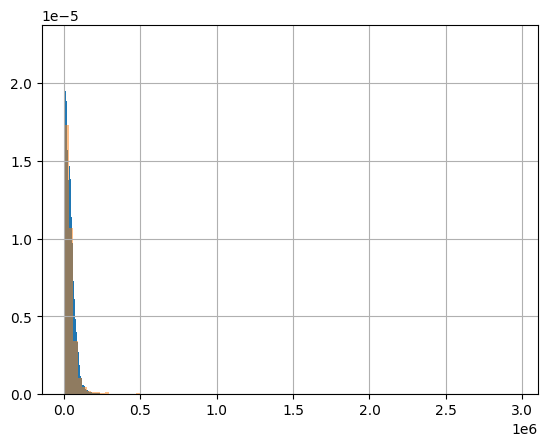

In [180]:
ss['price'].hist(bins=100, density=True)
train['price'].hist(bins=100, alpha=0.5, density=True)